In [10]:
#Bloque 1: Configuración Base
#Importe de librerías (torch, matplotlib, numpy) y definir constantes (tamaño de batch, learning rate, dispositivo CPU/GPU).

#Cambios globales se aplican aquí.


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
# 1. CONFIGURACIÓN Y DATOS
# -----------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), # Convierte imagen (0-255) a Tensor (0-1)
     transforms.Normalize((0.5), (0.5)) # Resta 0.5 y divide por 0.5 -> Rango (-1, 1)
    ])
print("Cargando datos...")

#transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

#datasets.MNIST: Descarga las 60,000 imágenes de números manuscritos.
data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)
# DataLoader: No se le pasan las 60,000 imágenes de golpe a la red (explotaría la memoria RAM). 
# El DataLoader es un "camarero" que le sirve a la red bandejas (batches) de 64 imágenes cada vez.
#shuffle=True:Evita la memorización, para así poder aprender a reconocer la imagen.
mnist_data_valid = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)

100%|██████████| 9.91M/9.91M [00:05<00:00, 1.77MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 181kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.45MB/s]


In [3]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [4]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# Input [-1, +1] -> use nn.Tanh

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
# model = Autoencoder()  # Usa este para autoencoder convolutivo para la práctica
model = Autoencoder_Linear()

criterion = nn.MSELoss()
#"Mean Squared Error" (Error Cuadrático Medio). Es la fórmula que calcula la nota del examen.
#Compara: Píxel de salida - Píxel de entrada.
#Si la imagen es idéntica, el Loss es 0.

optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

#optimizer = ...Adam: Es el algoritmo matemático que ajusta los "tornillos" (pesos) de la red para bajar el Loss.

In [ ]:
# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs): 
    for (img, _) in data_loader: # Carga un lote de 64 imágenes

        # APLANA la imagen: Convierte matriz 28x28 en vector de 784
        # Esto es OBLIGATORIO para el modelo Autoencoder_Linear
        img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)  # 1. Forward: La red intenta reconstruir
        loss = criterion(recon, img) # 2. Loss: Compara Reconstrucción vs Original
        
        #IMPORTANTE PARA CONVULUTIONAL AUTOENCODER:
        #img.reshape: Fíjate que está transformando la imagen cuadrada en una línea. 
        #Si quisiéramos usar el modelo Convolucional (Opción B), esta línea daría error, porque el modelo convolucional espera cuadrados.
        optimizer.zero_grad() # Limpia residuos anteriores
        loss.backward() # 3. Backward: Calcula dónde se equivocó (gradientes)
        optimizer.step() # 4. Step: Corrige los pesos

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0523
Epoch:2, Loss:0.0409
Epoch:3, Loss:0.0436
Epoch:4, Loss:0.0386
Epoch:5, Loss:0.0396
Epoch:6, Loss:0.0375
Epoch:7, Loss:0.0379
Epoch:8, Loss:0.0352
Epoch:9, Loss:0.0348
Epoch:10, Loss:0.0385


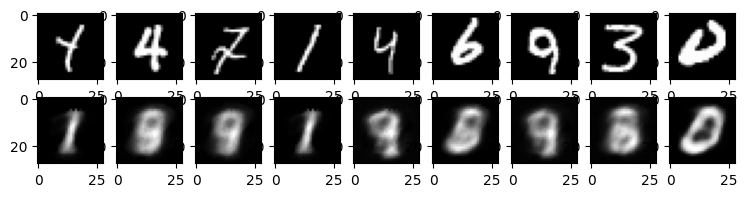

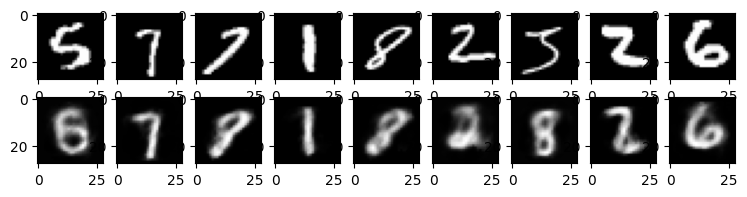

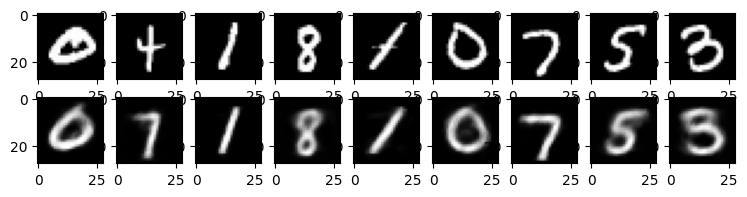

In [8]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

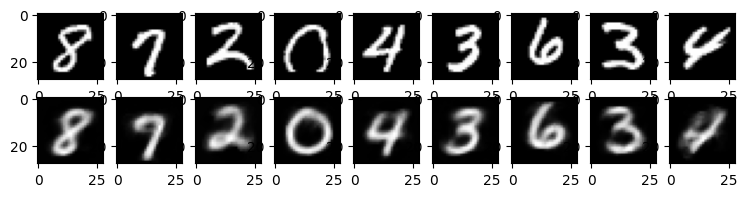

In [9]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)

img = images[0]

plt.figure(figsize=(9, 2))
plt.gray()


for i, img in enumerate(images[:9]):
    with torch.no_grad():
        img2 = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        pred = model(img2)
        recon = pred[0].detach().numpy()
        recon2 = recon.reshape(-1, 28,28) # -> use for Autoencoder_Linear

        plt.subplot(2, 9, i+1)
        plt.imshow(img[0])

        plt.subplot(2, 9, i+1+9)
        plt.imshow(recon2[0])